In [1]:
# Note: MUST load python/anaconda-2021.05
import pandas as pd
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from datetime import timedelta
os.chdir('/project/graziul/transcripts/')

In [2]:
today = datetime.today().strftime('%Y-%m-%d')
today = today.replace('-','_')
today

'2021_09_30'

In [3]:
# Get files
dirs_cnet = glob.glob('*' + os.path.sep)
dirs_cnet = [i for i in dirs_cnet if i != 'Raw/']
zones = ['Zone1','Zone4','Zone8']
dirs= []
for zone in zones:
    dirs += [i+zone+'/' for i in dirs_cnet if os.path.exists(i+zone+'/')]

In [4]:
dirs

['huthealex/Zone1/',
 'kristinakim/Zone1/',
 'tcjacksonsaitz/Zone1/',
 'wdolan/Zone1/',
 'kayawest/Zone1/',
 'chu16/Zone1/',
 'oabiona/Zone1/',
 'alexjrosado/Zone1/',
 'mhayford/Zone1/',
 'mirandgw/Zone1/',
 'sabajohnson/Zone1/',
 'hszymanek/Zone1/',
 'ryanhathaway/Zone1/',
 'kjcoleman/Zone1/',
 'wahid/Zone1/',
 'aekim22/Zone1/',
 'clarkmoody/Zone1/',
 'tcjacksonsaitz/Zone4/',
 'wdolan/Zone4/',
 'chu16/Zone4/',
 'alexjrosado/Zone4/',
 'mhayford/Zone4/',
 'mirandgw/Zone4/',
 'sabajohnson/Zone4/',
 'hszymanek/Zone4/',
 'ryanhathaway/Zone4/',
 'aliasmith/Zone4/',
 'clarkmoody/Zone4/',
 'wdolan/Zone8/',
 'sabajohnson/Zone8/',
 'xuranzeng/Zone8/',
 'aliasmith/Zone8/']

In [5]:
list_of_transcripts = []
num_files = 0
num_files_processed = 0
for user_dir in dirs:
    files = glob.glob(user_dir+'*.xlsx')+glob.glob(user_dir+'*.txt')
    for file in files:
        _, zone, _ = file.split('/')
        loaded_file=False
        num_files +=1
        if '.xlsx' in file:
            df_file = pd.read_excel(file)
            loaded_file=True
        if '.txt' in file: # and 'rah' not in file:
            df_file = pd.read_csv(file, sep='\t',names=['start','end','label'])
            loaded_file=True
            def parse_label(l):
                try:
                    try:
                        parsed_label = l.split(';')
                    except:
                        print(file, l)
                    parsed_label = [i for i in parsed_label if 'seconds' not in i]
                    if len(parsed_label)==0:
                        return pd.Series(['','',''], index=['sid','transcription','notes'])
                    if len(parsed_label)==1:
                        return pd.Series(['']+parsed_label+[''], index=['sid','transcription','notes'])
                    if len(parsed_label)==2:
                        return pd.Series(parsed_label+[''],index=['sid','transcription','notes'])
                    if len(parsed_label)==3:
                        return pd.Series(parsed_label, index=['sid','transcription','notes'])
                    else:
                        print(file, l, parsed_label)
                except:
                    print(file, l, parsed_label)
            df_file[['sid','transcription','notes']] = df_file['label'].apply(lambda x: parse_label(x))
            df_file = df_file.drop(['label'], axis=1)
            def get_hms(x):
                m, s = divmod(x,60)
                m_str = str(round(m))
                s_str = str(round(s,3))
                return '00.'+m_str+'.'+s_str
            df_file['start'] = df_file['start'].apply(lambda x: get_hms(x))
            df_file['end'] = df_file['end'].apply(lambda x: get_hms(x))
        # Check that file was loaded
        if loaded_file:
            # Change variable names as needed
            df_file.rename(columns= lambda x: x.strip(),inplace=True)
            df_file.rename(columns= lambda x: x.lower(),inplace=True)
            df_file.rename(columns= {'speaker id':'sid',
                                    'speaker ut':'sid',
                                    'speaker utt':'sid',
                                    'speakerutt':'sid',
                                    'speaker':'sid',
                                    'start .1':'start',
                                    'time.start':'start',
                                    'start time':'start',
                                    'time.stop':'end',
                                    'time.end':'end',
                                    'end time':'end',
                                    'stop':'end',
                                    'top':'end',
                                    'note':'notes',
                                    'unnamed: 4':'notes'},inplace=True)
            metadata = file.split('.')[0].split('/')[-1]
            df_file['year'] = int(metadata[0:4])
            df_file['month'] = int(metadata[4:6])
            df_file['day'] = int(metadata[6:8])
            df_file['time'] = int(metadata[8:12])
            df_file['feed'] = int(metadata.split('-')[2][0:5])
            df_file['zone'] = zone
            df_file['file'] = file.split('/')[-1]
            df_file['transcriber'] = file.split('/')[0]
            num_files_processed+=1
            # Keep only what we need
            try:
                df_file = df_file[['feed','zone','year','month','day','time','sid','start','end','transcription','notes','file','transcriber']]
            except:
                print(file,df_file.columns.values)
            if len(list_of_transcripts)==0:
                list_of_transcripts = [df_file]
            else:
                list_of_transcripts.append(df_file)
df_transcripts = pd.concat(list_of_transcripts).reset_index(drop=True)
num_snippets = len(df_transcripts)
print('Number of total files: '+str(num_files)+'\nNumber of processed files: '+str(num_files_processed)+'\nNumber of utterances: '+str(num_snippets))

Number of total files: 402
Number of processed files: 402
Number of utterances: 51730


In [6]:
def clean_timestamp(t):
    t = str(t).replace(':','.')
    t = t.replace(';','.')
    # Remove extra period
    t = t.replace('..','.')
    t = t.replace("'","")
    parsed = t.split('.')
    # Remove spaces
    parsed = [i.strip() for i in parsed]
    if len(parsed)==4:
        # Normal '00.#.#.#'
        return '.'.join(parsed[0:4])
    elif len(parsed)==3:
        # Idiosyncratic issue where '.#.#'
        if parsed[0]=='':
            return '.'.join(['00.00']+parsed[1:3])
        # More common issue where '#.#.#'
        else:
            return '.'.join(['00']+parsed[0:3])
    elif len(parsed)==2:
        # Situation where '#.#' (always seconds.milliseconds at start of file)
        return '.'.join(['00.00']+parsed)
    elif len(parsed)==1:
        # Situation where '#' (always '0' seconds indicating start of file)
        return '.'.join(['00.00']+parsed+['00'])
    else:
        print(t)
def try_clean(x):
    try:
        t = clean_timestamp(x)
        return t
    except:
        print(x)
df_transcripts['start_c'] = df_transcripts['start'].apply(lambda x: try_clean(x))
df_transcripts['start_dt'] = pd.to_datetime(df_transcripts['start_c'],format='%H.%M.%S.%f')
df_transcripts['end_c'] = df_transcripts['end'].apply(lambda x: try_clean(x))
df_transcripts['end_dt'] = pd.to_datetime(df_transcripts['end_c'],format='%H.%M.%S.%f')
df_transcripts['start'] = (df_transcripts['start_dt']-np.datetime64('1900-01-01T00:00:00.000000000')).dt.total_seconds()
df_transcripts['end'] = (df_transcripts['end_dt']-np.datetime64('1900-01-01T00:00:00.000000000')).dt.total_seconds()

<AxesSubplot:>

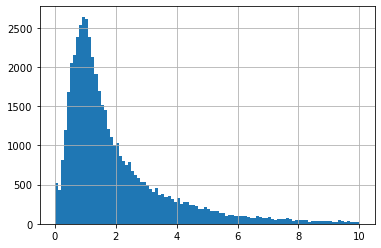

In [7]:
# Calculate length of time transcribed
df_transcripts['length'] = (df_transcripts['end']-df_transcripts['start'])
df_transcripts['length'].hist(bins=100,range=(0,10))

In [39]:
df_transcripts['length'].describe()

count    51730.000000
mean         2.215564
std         30.378892
min      -3300.786000
25%          0.865000
50%          1.420000
75%          2.660000
max       1626.936000
Name: length, dtype: float64

zone
Zone1    [[AxesSubplot(0.125,0.670278;0.775x0.209722)],...
Zone4    [[AxesSubplot(0.125,0.670278;0.775x0.209722)],...
Zone8    [[AxesSubplot(0.125,0.670278;0.775x0.209722)],...
dtype: object

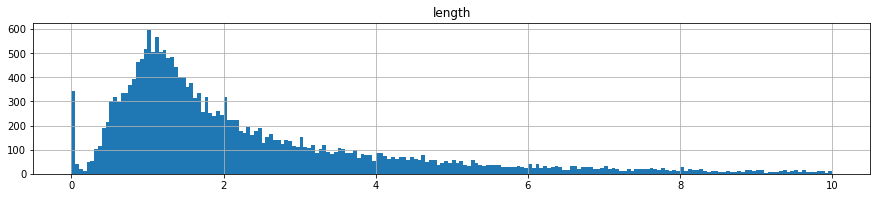

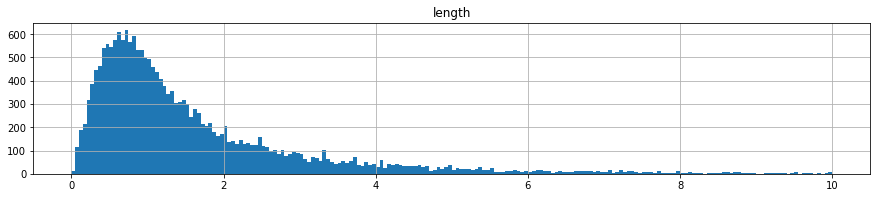

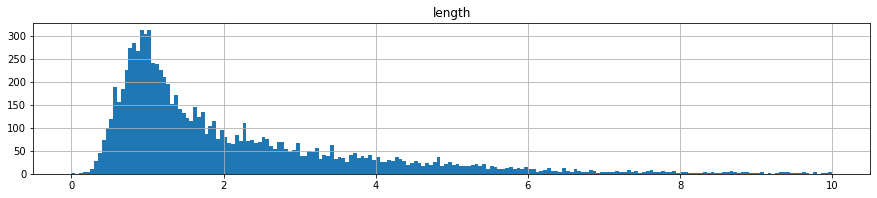

In [38]:
df_transcripts.groupby('zone').hist(column='length',bins=200,range=(0,10),layout=(3,1),figsize=(15,10), sharey=True)

In [8]:
# Find number of unique transcription file names
unique_transcripts = len(df_transcripts['file'].unique())
# Calculate approximate minutes transcribed
total_transcribed = unique_transcripts*30
# Find number of unique audio files transcribed
unique_files_transcribed = len(df_transcripts[['feed','year','month','day','time']].drop_duplicates())
print("Transcripts: "+str(unique_transcripts)+"\nAudio reviewed: About "+str(total_transcribed/60)+" hours\nUnique audio files: "+str(unique_files_transcribed)+"\nBPC coverage: About "+str(unique_files_transcribed*30/60)+" hours of working time")

Transcripts: 402
Audio reviewed: About 201.0 hours
Unique audio files: 219
BPC coverage: About 109.5 hours of working time


In [9]:
# Look for errors/outliers (anything negative is an error, anything more than 20 seconds is an outlier)
df_transcripts['length'].describe(include='all')

count    51730.000000
mean         2.215564
std         30.378892
min      -3300.786000
25%          0.865000
50%          1.420000
75%          2.660000
max       1626.936000
Name: length, dtype: float64

In [10]:
# Get a list of outliers to review organized by transcriber and filename
outlier_thresh = 25
df_outliers = df_transcripts.loc[(df_transcripts['length']<0) | (df_transcripts['length']>outlier_thresh),['transcriber','file','start','end','length']].sort_values(['file','transcriber']).reset_index(drop=True)
df_outliers.to_csv('outliers'+today+'.csv',index=False)
len(df_outliers)

203

In [11]:
def remove_irrelevant(x):
    x = str(x)
    x = x.replace("\[Uncertain\]","")
    x = x.replace("INAUDIBLE","")    
    x = x.replace("<X>","")
    x = x.replace("-"," ")
    x = ' '.join(x.split())
    x = ''.join([i for i in x if i.isalnum() or i==' '])
    x = x.strip()
    x = x.upper()
    return x

In [12]:
df_transcripts_all = df_transcripts.copy()
df_transcripts_all['index']=df_transcripts_all.index
df_transcripts_all = df_transcripts_all[[i for i in df_transcripts_all.columns.values if i not in ['start_c','start_dt','end_c','end_dt']]]
df_transcripts_all.to_csv('transcripts_raw'+today+'.csv',index=False)
df_transcripts_all.head()

,feed,zone,year,month,day,time,sid,start,end,transcription,notes,file,transcriber,length,index
0,27730,Zone1,2018,8,12,932,RADIO,141.252,151.279,RADIOSHOP TESTING ONE TWO THREE FOUR FIVE FIVE...,NaN,201808120932-28710-27730ah.xlsx,huthealex,10.027,0
1,27730,Zone1,2018,8,12,932,RADIO,158.109,159.417,ONE TWO ONE TWO,NaN,201808120932-28710-27730ah.xlsx,huthealex,1.308,1
2,27730,Zone1,2018,8,12,932,UNIT,168.327,169.235,UNIT COMING IN,NaN,201808120932-28710-27730ah.xlsx,huthealex,0.908,2
3,27730,Zone1,2018,8,12,932,UNIT,175.330,177.437,ZONE ONE IS ON CITY [WIDE] FIVE,NaN,201808120932-28710-27730ah.xlsx,huthealex,2.107,3
4,27730,Zone1,2018,8,12,932,RADIO,184.003,189.017,OKAY THANKS UH THIS IS THE RADIO SHOP TESTING ...,NaN,201808120932-28710-27730ah.xlsx,huthealex,5.014,4


In [13]:
df_transcripts_forcoding = df_transcripts_all[['index','transcription']].copy()
df_transcripts_forcoding['transcription'] = df_transcripts_forcoding['transcription'].apply(remove_irrelevant)
df_transcripts_forcoding = df_transcripts_forcoding.sample(frac=1)
df_transcripts_forcoding.to_csv('transcripts_forcoding'+today+'.csv',index=False)
df_transcripts_forcoding.head()

,index,transcription
25111,25111,I THINK THEY WENT OVER ON WABASH THERE NEXT TO UH
48127,48127,UH SIX ELEVEN
47908,47908,TEN FOUR
39131,39131,YOU GET UP AND ROLL AND I GOT AN INFO FOR THE ...
49240,49240,NO ONE


In [14]:
# NOTE: Manually change index based on above to ensure alignment
df_transcripts_forcoding[df_transcripts_forcoding['index']==40818]

,index,transcription
40818,40818,ALRIGHT UH EIGHTEEN TEN ROBERT


In [15]:
# Get total transcribed without errors/outliers
num_utterances_noprob = len(df_transcripts[(df_transcripts['length']>0) & (df_transcripts['length']<outlier_thresh)])
df_transcripts_noprob = df_transcripts[(df_transcripts['length']>0) & (df_transcripts['length']<outlier_thresh)]
df_transcripts_noprob.loc[:,('transcription')] = df_transcripts_noprob['transcription'].str.upper()
df_transcripts_noprob.to_csv('transcripts'+today+'.csv',index=False)
df_transcripts_noprob[[i for i in df_transcripts_noprob.columns.values if i != 'transcriber']].to_csv('transcripts_noid'+today+'.csv',index=False)
minutes_transcribed_noprob = df_transcripts_noprob['length'].sum()/60
print("Utterances transcribed: "+str(num_utterances_noprob)+"\nAudio transcribed: "+str(round(minutes_transcribed_noprob/60,1))+" hours")

/home/graziul/.conda/envs/deepspeech/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Utterances transcribed: 51474
Audio transcribed: 31.9 hours


In [16]:
df_transcripts_noprob[['transcriber','file']].drop_duplicates().groupby('transcriber').count()/5

,file
transcriber,
aekim22,3.0
alexjrosado,3.0
aliasmith,4.0
chu16,2.0
clarkmoody,2.0
hszymanek,9.0
huthealex,3.0
kayawest,1.0
kjcoleman,3.4


In [17]:
df_total_minutes = df_transcripts_noprob.groupby('transcriber')['length'].sum()/60
df_total_minutes = df_total_minutes.reset_index()
df_total_minutes = df_total_minutes.rename(columns={'length':'minutes'})
df_total_minutes.to_csv('minutes_transcribed'+today+'.csv',index=False)
df_total_minutes['percent'] = round(100*df_total_minutes['minutes']/df_total_minutes['minutes'].sum(),1)
df_total_minutes

,transcriber,minutes,percent
0,aekim22,69.652000,3.6
1,alexjrosado,99.247200,5.2
2,aliasmith,162.042867,8.5
3,chu16,64.519567,3.4
4,clarkmoody,46.757383,2.4
5,hszymanek,148.449978,7.8
6,huthealex,57.835240,3.0
7,kayawest,11.156917,0.6
8,kjcoleman,67.637773,3.5
9,kristinakim,15.433217,0.8


In [18]:
def modification_date(file):
    t = os.path.getmtime(file)
    return datetime.fromtimestamp(t)
def get_mod_date(x):
    transcriber, zone, file = x
    mod_date = modification_date(transcriber+'/'+zone+'/'+file)
    return mod_date

In [19]:
df_files = df_transcripts[['transcriber','zone','file']].drop_duplicates().reset_index(drop=True)
df_files['mod_date'] = df_files.apply(lambda x: get_mod_date(x),axis=1)
df_files['week_num'] = df_files['mod_date'].apply(lambda x: (x + timedelta(days=1)).week)
df_files.head()

,transcriber,zone,file,mod_date,week_num
0,huthealex,Zone1,201808120932-28710-27730ah.xlsx,2021-04-12 16:53:43,15
1,huthealex,Zone1,201808120304-366043-27730ah.xlsx,2021-04-02 13:35:25,13
2,huthealex,Zone1,201808120902-41159-27730ah.xlsx,2021-04-12 16:53:43,15
3,huthealex,Zone1,201808120234-654163-27730ah.xlsx,2021-04-01 09:54:21,13
4,huthealex,Zone1,201808120135-851247-27730ah.xlsx,2021-04-02 13:37:11,13


In [20]:
df_temp = df_transcripts_noprob[['transcriber','zone','file','length_s']].merge(df_files[['transcriber','zone','file','week_num']],on=['transcriber','zone','file'])
df_temp.head()

KeyError: "['length_s'] not in index"

In [ ]:
df_temp['week_num'].describe()

In [ ]:
df_temp.groupby(['week_num'])['length_s'].sum()/60

In [ ]:
df_productivity = df_temp.groupby(['transcriber','week_num'])['length_s'].sum().reset_index()
df_productivity['length_m'] = df_productivity['length_s']/60
df_productivity

In [ ]:
df_weekly_hours = pd.read_csv('weekly_hours.csv')
df_productivity = df_productivity.merge(df_weekly_hours,left_on=['transcriber','week_num'],right_on=['User','week_num'])
df_productivity.drop(columns=['length_s','User'],inplace=True)
df_productivity['rate'] = (df_productivity['session_hours']*60)/df_productivity['length_m']
df_productivity.head()

In [ ]:
df_productivity.groupby(['transcriber'])['rate'].describe()

In [ ]:
df_productivity_weekly = df_productivity.groupby(['week_num'])[['length_m','session_hours']].agg(sum)
df_productivity_weekly['rate'] = (df_productivity_weekly['session_hours']*60)/df_productivity_weekly['length_m']
df_productivity_weekly

In [ ]:
df_productivity_weekly.plot.bar(y='length_m')

In [ ]:
df_total_transcribed = df_productivity_weekly['length_m'].cumsum().reset_index()
df_total_transcribed['Total Hours'] = df_total_transcribed['length_m']/60
df_total_transcribed.plot.bar(x='week_num',y='Total Hours')

In [ ]:
df_productivity_weekly['rate'].plot()

In [ ]:
# Assume 20 min to transcribe 1 min of audio, and 18.4 hrs of 100 hrs of audio are complete
transcription_rate = 20
minutes_to_transcribe = (100-minutes_transcribed_noprob/60)*60
hours_work_remaining = (minutes_to_transcribe*transcription_rate)/60
# Assume 20 hrs/week per transcriber
transcriber_weeks = hours_work_remaining/20
# Assume 6 transcribers
transcriber_weeks/6

In [ ]:
t = df_productivity.groupby(['week_num'])['length_m'].sum().reset_index()
t

In [ ]:
(100-minutes_transcribed_noprob/60)*60*10/60

In [ ]:
minutes_to_transcribe, hours_work_remaining, transcriber_weeks

In [ ]:
transcriber_weeks/6